State: (0, 0), Action: RIGHT, Next: (1, 0), Reward: -1


/var/folders/j4/2nwxqq795dq2735xfprfpxkm0000gn/T/ipykernel_89652/3517284054.py:119: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdGy', 5)


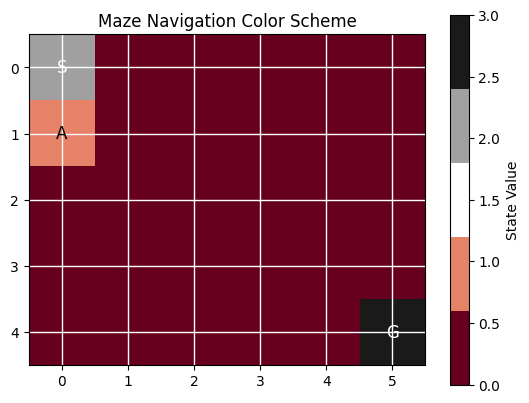

State: (1, 0), Action: RIGHT, Next: (1, 1), Reward: -1


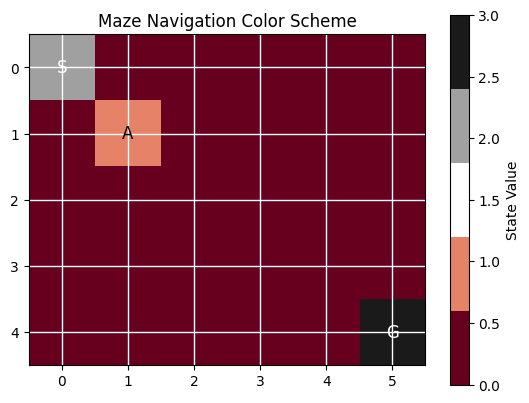

State: (1, 1), Action: RIGHT, Next: (1, 2), Reward: -1


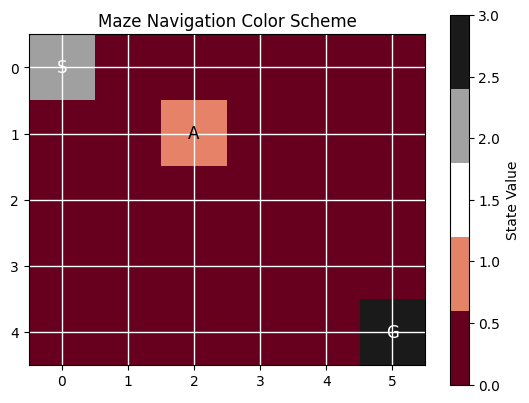

State: (1, 2), Action: RIGHT, Next: (1, 3), Reward: -1


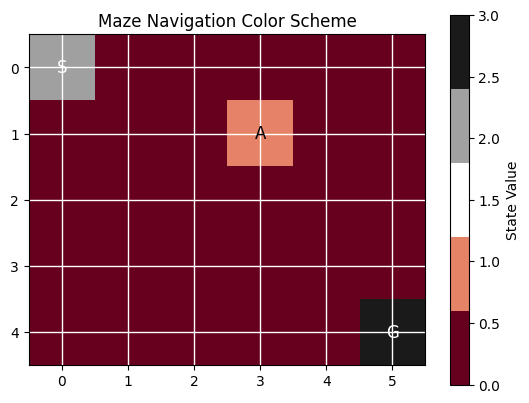

State: (1, 3), Action: DOWN, Next: (1, 3), Reward: -10


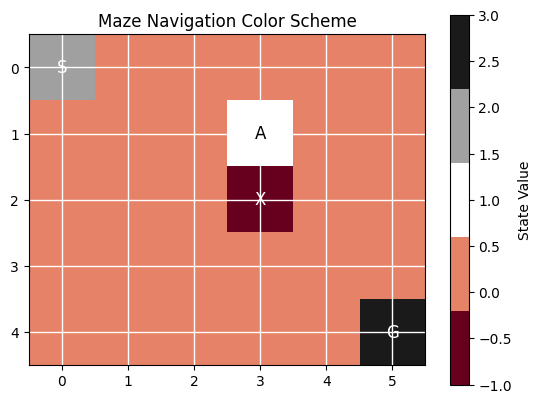

State: (1, 3), Action: RIGHT, Next: (1, 4), Reward: -1


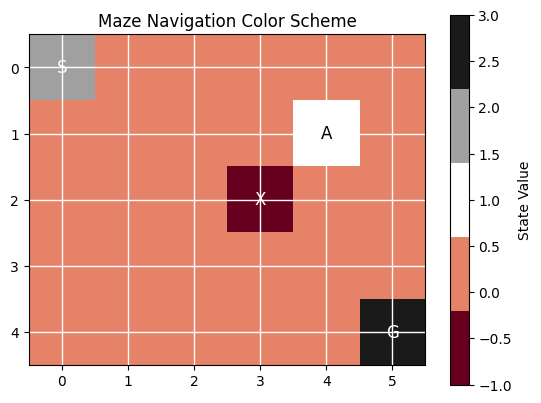

State: (1, 4), Action: DOWN, Next: (2, 4), Reward: -1


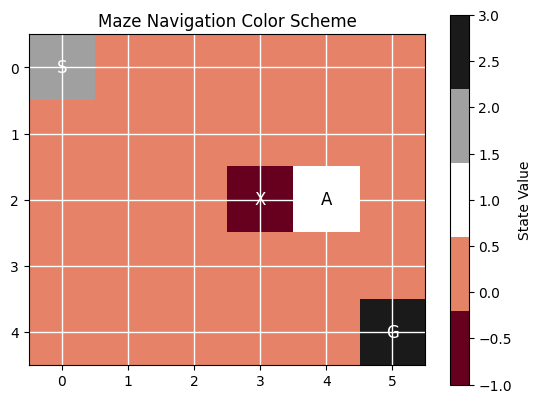

State: (2, 4), Action: DOWN, Next: (2, 4), Reward: -10


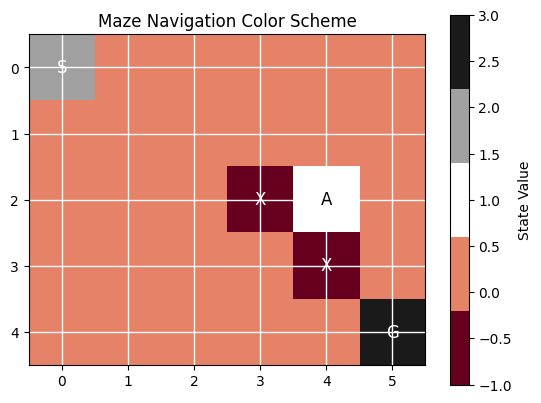

State: (2, 4), Action: RIGHT, Next: (2, 5), Reward: -1


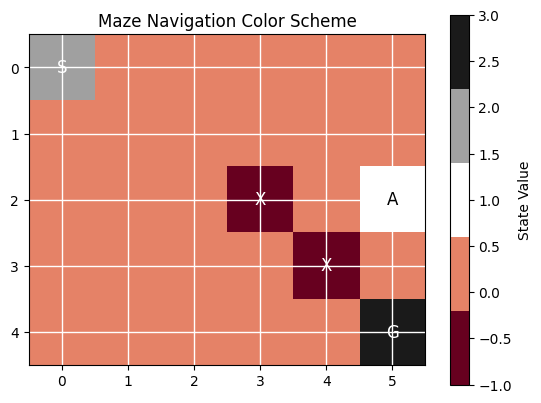

State: (2, 5), Action: DOWN, Next: (3, 5), Reward: -1


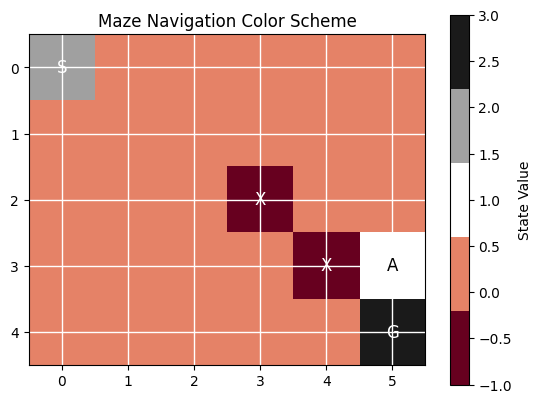

State: (3, 5), Action: DOWN, Next: (4, 5), Reward: 100


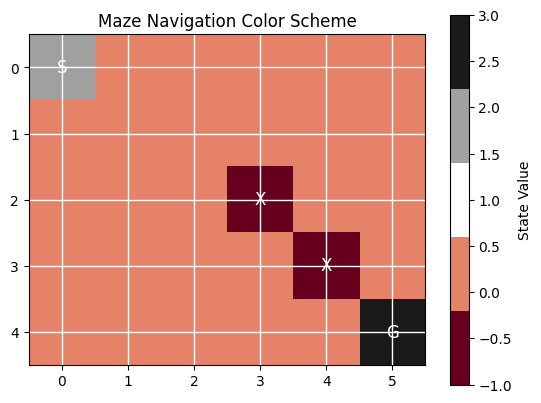


Final Path to Goal:
[(0, 0), (1, 0), (1, 1), (1, 2), (1, 3), (1, 3), (1, 4), (2, 4), (2, 4), (2, 5), (3, 5), (4, 5)]


In [7]:
import random
import time
import matplotlib.pyplot as plt
import numpy as np
# Maze Setup
ROWS, COLS = 5, 6
START_STATE = (0, 0)
GOAL_STATE = (4, 5)
TRUE_OBSTACLES = {(0, 1), (2, 1), (2, 3), (3, 1), (3, 4), (4, 4)}
ACTIONS = ['UP', 'DOWN', 'LEFT', 'RIGHT']
ACTION_PROBS = {
    'UP':    {'UP': 0.8, 'LEFT': 0.1, 'RIGHT': 0.1},
    'DOWN':  {'DOWN': 0.8, 'LEFT': 0.1, 'RIGHT': 0.1},
    'LEFT':  {'LEFT': 0.8, 'UP': 0.1, 'DOWN': 0.1},
    'RIGHT': {'RIGHT': 0.8, 'UP': 0.1, 'DOWN': 0.1},
}
# Global Known Obstacles Set
known_obstacles = set()
# Helper Functions
def is_out_of_bounds(state):
    r, c = state
    return r < 0 or r >= ROWS or c < 0 or c >= COLS

def is_real_obstacle(state):
    return state in TRUE_OBSTACLES

def get_next_state(state, action):
    r, c = state
    if action == 'UP': return (r - 1, c)
    if action == 'DOWN': return (r + 1, c)
    if action == 'LEFT': return (r, c - 1)
    if action == 'RIGHT': return (r, c + 1)

def get_all_states():
    return [(r, c) for r in range(ROWS) for c in range(COLS) if (r, c) not in known_obstacles]
# Value Iteration
def value_iteration(states, gamma=0.9, epsilon=0.1):
    V = {s: 0 for s in states}
    while True:
        delta = 0
        new_V = V.copy()
        for state in states:
            if state == GOAL_STATE:
                new_V[state] = 0
                continue
            max_utility = float('-inf')
            for action in ACTIONS:
                expected_utility = 0
                for a_prime, prob in ACTION_PROBS[action].items():
                    next_state = get_next_state(state, a_prime)
                    if is_out_of_bounds(next_state) or next_state in known_obstacles:
                        reward = -10
                        next_state = state
                    elif next_state == GOAL_STATE:
                        reward = 100
                    else:
                        reward = -1
                    expected_utility += prob * (reward + gamma * V.get(next_state, 0))
                max_utility = max(max_utility, expected_utility)
            new_V[state] = max_utility
            delta = max(delta, abs(new_V[state] - V[state]))
        V = new_V
        if delta < epsilon:
            break
    return V
# Policy Extraction
def extract_policy(V, states):
    policy = {}
    for state in states:
        if state == GOAL_STATE:
            policy[state] = None
            continue
        best_action = None
        best_value = float('-inf')
        for action in ACTIONS:
            expected_utility = 0
            for a_prime, prob in ACTION_PROBS[action].items():
                next_state = get_next_state(state, a_prime)
                if is_out_of_bounds(next_state) or next_state in known_obstacles:
                    reward = -10
                    next_state = state
                elif next_state == GOAL_STATE:
                    reward = 100
                else:
                    reward = -1
                expected_utility += prob * (reward + V.get(next_state, 0))
            if expected_utility > best_value:
                best_value = expected_utility
                best_action = action
        policy[state] = best_action
    return policy
# Movement Simulation
def simulate_move(state, action):
    prob_dist = ACTION_PROBS[action]
    rand = random.random()
    cumulative = 0.0
    for a_prime, prob in prob_dist.items():
        cumulative += prob
        if rand < cumulative:
            intended_state = get_next_state(state, a_prime)
            break
    if is_out_of_bounds(intended_state) or is_real_obstacle(intended_state):
        known_obstacles.add(intended_state)
        return state, -10
    return intended_state, 100 if intended_state == GOAL_STATE else -1
# Visualization
def visualize_maze(agent_pos):
    """Visualize the maze with a more advanced and contrasting color scheme."""
    maze = np.zeros((ROWS, COLS))
    for r in range(ROWS):
        for c in range(COLS):
            if (r, c) in known_obstacles:
                maze[r, c] = -1
    maze[START_STATE[0], START_STATE[1]] = 2
    maze[GOAL_STATE[0], GOAL_STATE[1]] = 3
    if agent_pos != START_STATE and agent_pos != GOAL_STATE:
        maze[agent_pos[0], agent_pos[1]] = 1

    cmap = plt.cm.get_cmap('RdGy', 5)
    cmap.set_under('darkred')
    cmap.set_over('darkgreen')
    cmap.set_bad('black')

    plt.imshow(maze, cmap=cmap, interpolation='nearest')
    plt.colorbar(label='State Value')
    plt.title("Maze Navigation Color Scheme")
    plt.xticks(np.arange(0, COLS, 1))
    plt.yticks(np.arange(0, ROWS, 1))
    plt.grid(which='both', color='white', linestyle='-', linewidth=1)

    for (r, c), value in np.ndenumerate(maze):
        if value == -1:
            plt.text(c, r, 'X', ha='center', va='center', color='white', fontsize=12)
        elif value == 2:
            plt.text(c, r, 'S', ha='center', va='center', color='white', fontsize=12)
        elif value == 3:
            plt.text(c, r, 'G', ha='center', va='center', color='white', fontsize=12)
        elif value == 1:
            plt.text(c, r, 'A', ha='center', va='center', color='black', fontsize=12)

    plt.show()
# Main Loop: Navigate Through Maze
def main():
    current_state = START_STATE
    path = [current_state]

    while current_state != GOAL_STATE:
        states = get_all_states()
        V = value_iteration(states)
        policy = extract_policy(V, states)
        action = policy.get(current_state)
        if action is None:
            print("No available action from", current_state)
            break
        next_state, reward = simulate_move(current_state, action)
        print(f"State: {current_state}, Action: {action}, Next: {next_state}, Reward: {reward}")
        visualize_maze(next_state)
        path.append(next_state)
        current_state = next_state

    print("\nFinal Path to Goal:")
    print(path)

if __name__ == "__main__":
    main()


Starting Stochastic Maze Navigation...
Maze Size: 5x6
Start: (0, 0), Goal: (4, 5)
True Obstacles: {(0, 1), (4, 4), (2, 3), (3, 4), (2, 1), (3, 1)}

=== Step 1 ===
State: (0, 0), Action: RIGHT, Next: (0, 0), Reward: -10


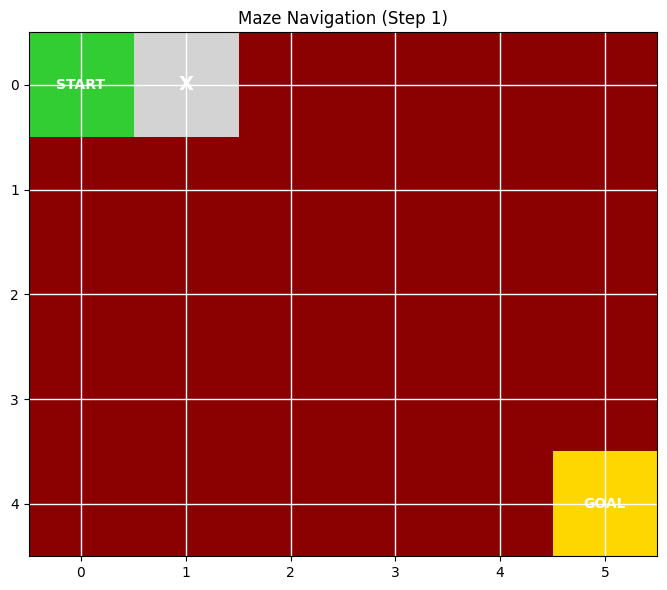


=== Step 2 ===
State: (0, 0), Action: DOWN, Next: (0, 0), Reward: -10


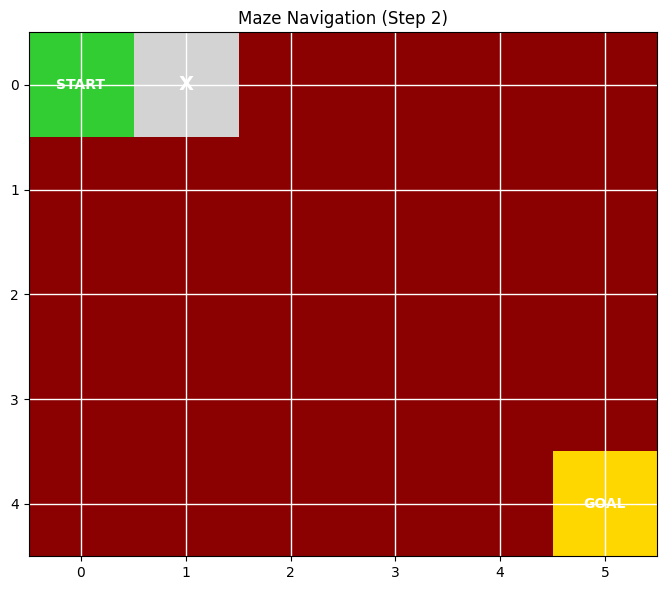


=== Step 3 ===
State: (0, 0), Action: DOWN, Next: (1, 0), Reward: -1


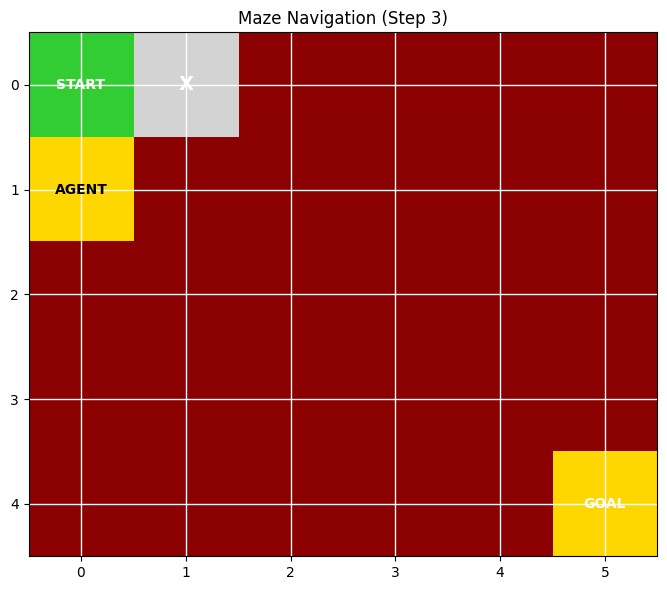


=== Step 4 ===
State: (1, 0), Action: RIGHT, Next: (1, 1), Reward: -1


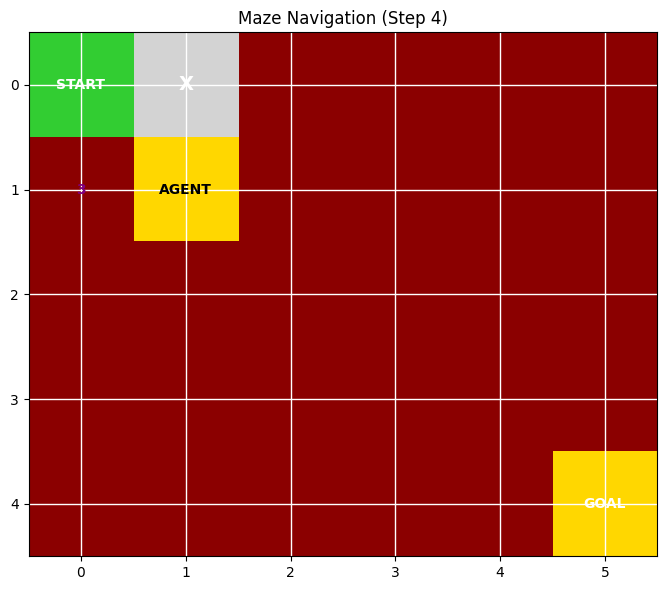


=== Step 5 ===
State: (1, 1), Action: DOWN, Next: (1, 1), Reward: -10


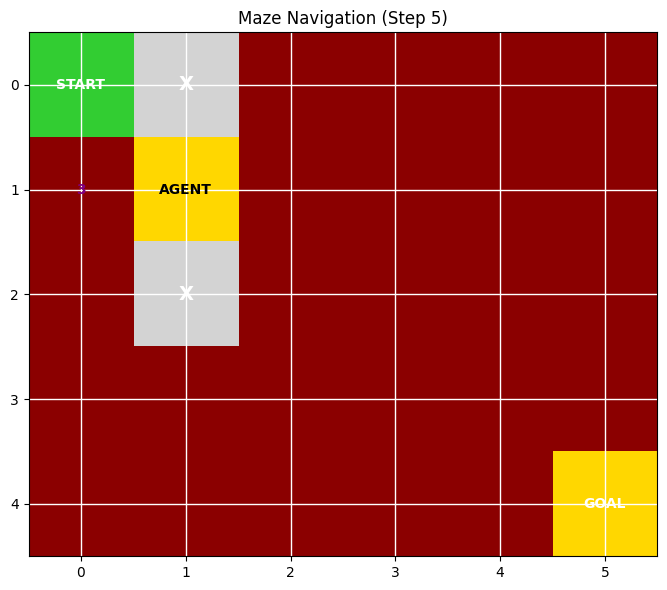


=== Step 6 ===
State: (1, 1), Action: RIGHT, Next: (1, 2), Reward: -1


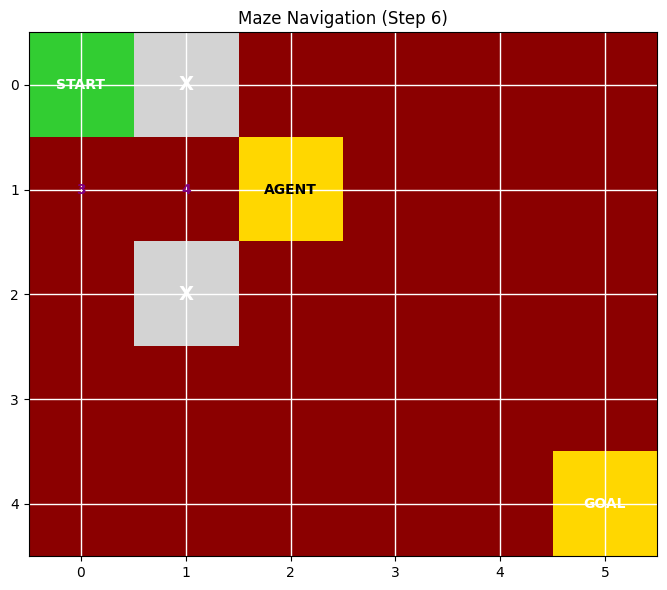


=== Step 7 ===
State: (1, 2), Action: RIGHT, Next: (1, 3), Reward: -1


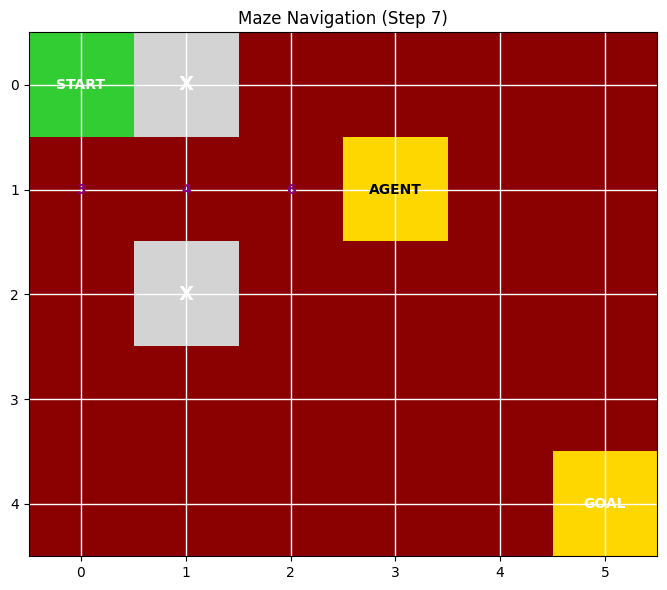


=== Step 8 ===
State: (1, 3), Action: DOWN, Next: (1, 3), Reward: -10


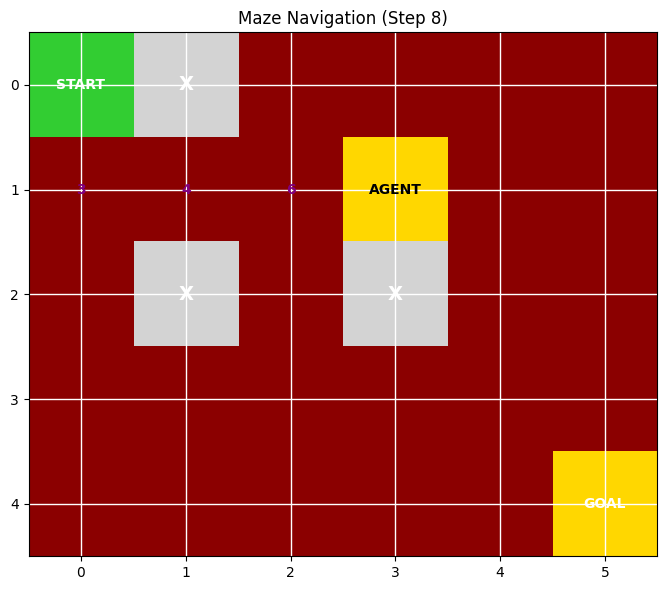


=== Step 9 ===
State: (1, 3), Action: RIGHT, Next: (1, 4), Reward: -1


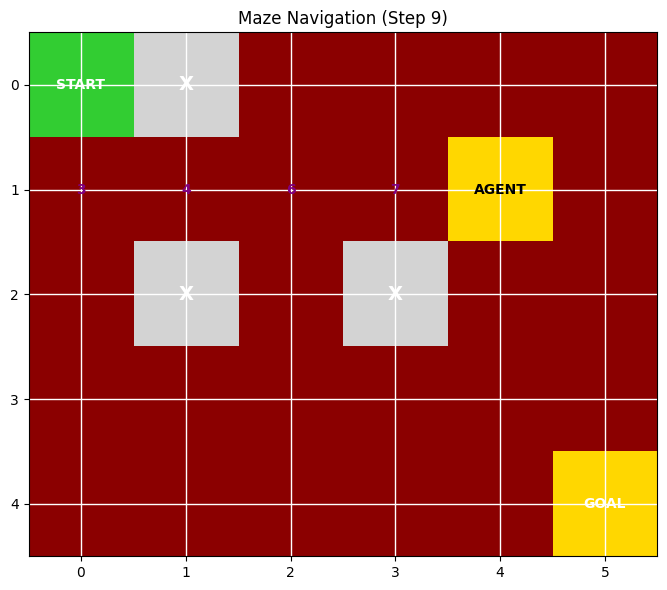


=== Step 10 ===
State: (1, 4), Action: DOWN, Next: (1, 5), Reward: -1


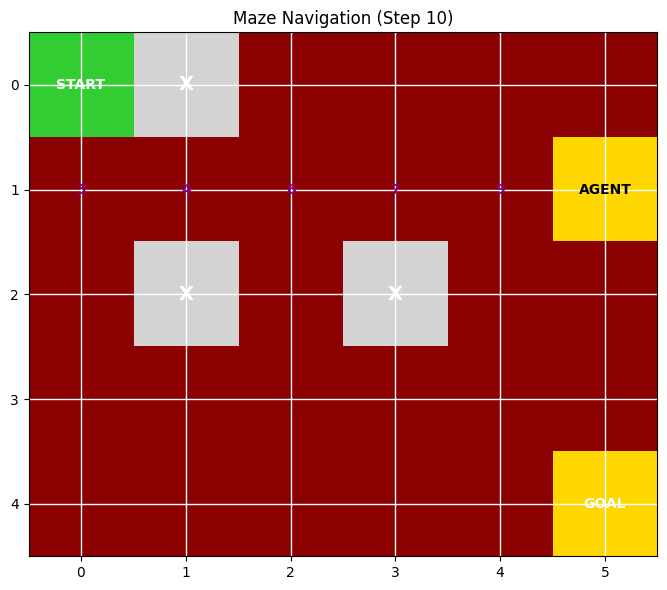


=== Step 11 ===
State: (1, 5), Action: DOWN, Next: (2, 5), Reward: -1


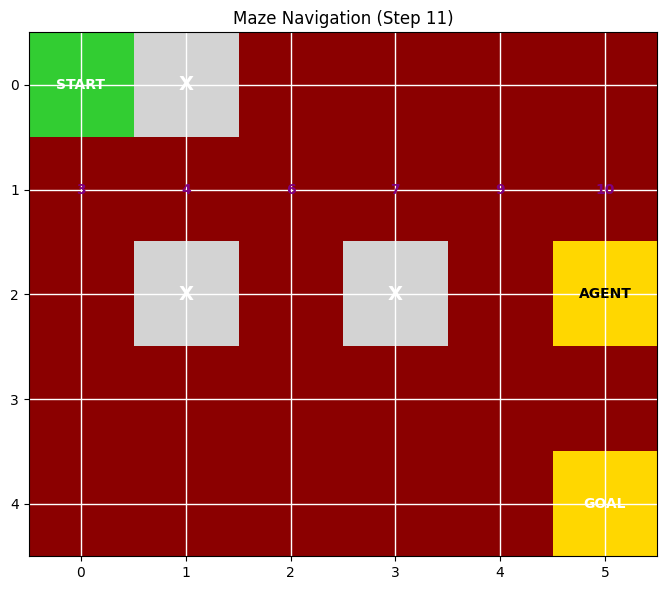


=== Step 12 ===
State: (2, 5), Action: DOWN, Next: (2, 4), Reward: -1


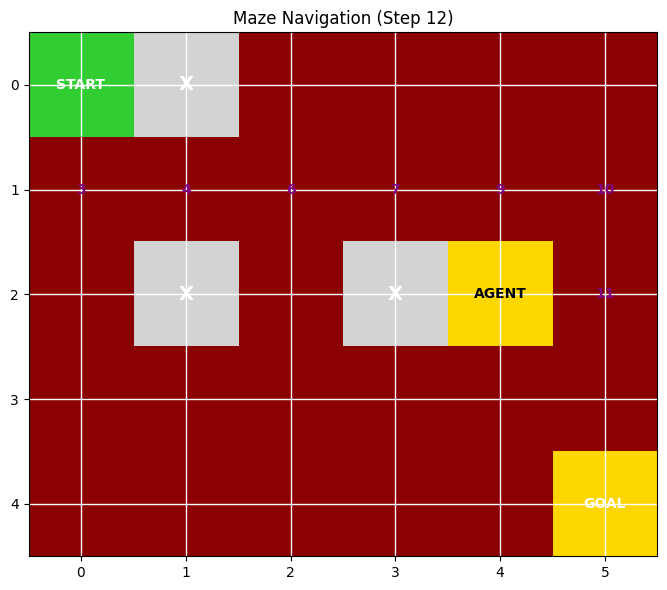


=== Step 13 ===
State: (2, 4), Action: DOWN, Next: (2, 4), Reward: -10


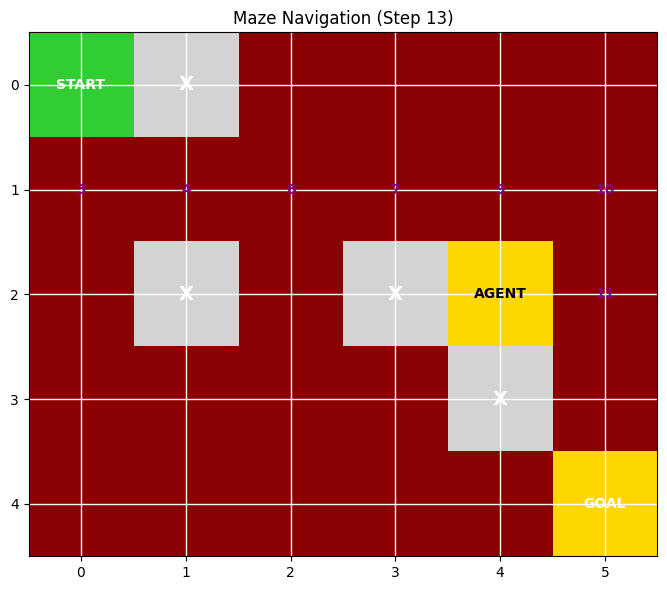


=== Step 14 ===
State: (2, 4), Action: RIGHT, Next: (2, 5), Reward: -1


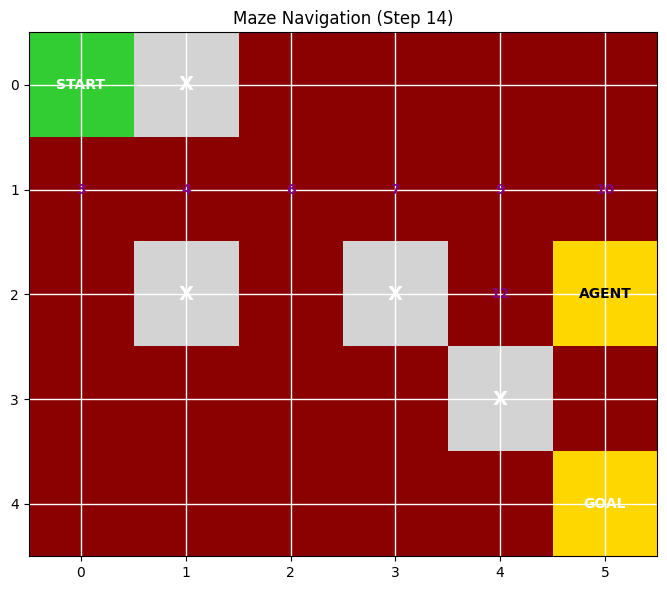


=== Step 15 ===
State: (2, 5), Action: DOWN, Next: (3, 5), Reward: -1


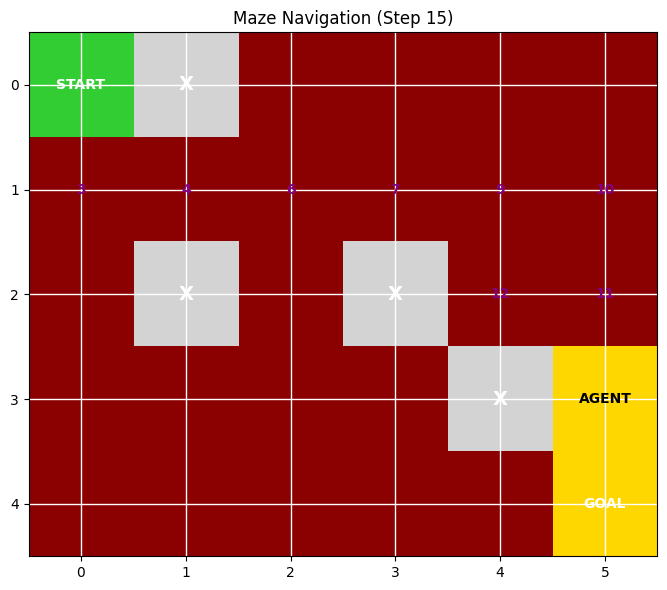


=== Step 16 ===
State: (3, 5), Action: DOWN, Next: (3, 5), Reward: -10


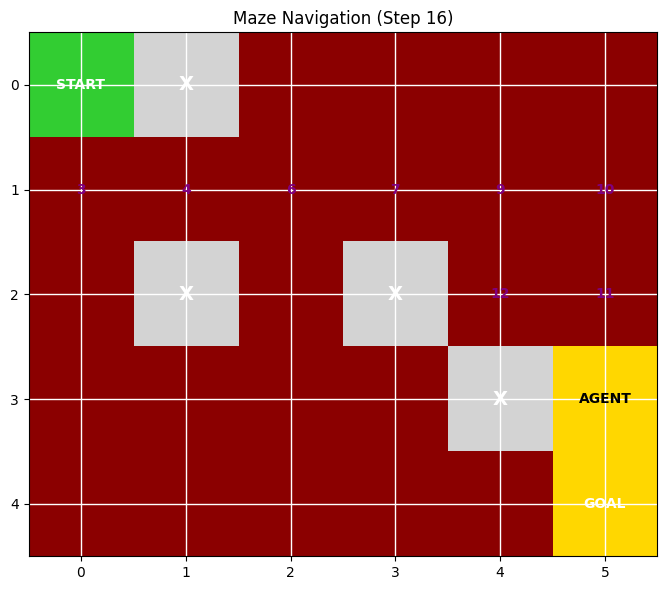


=== Step 17 ===
State: (3, 5), Action: DOWN, Next: (3, 5), Reward: -10


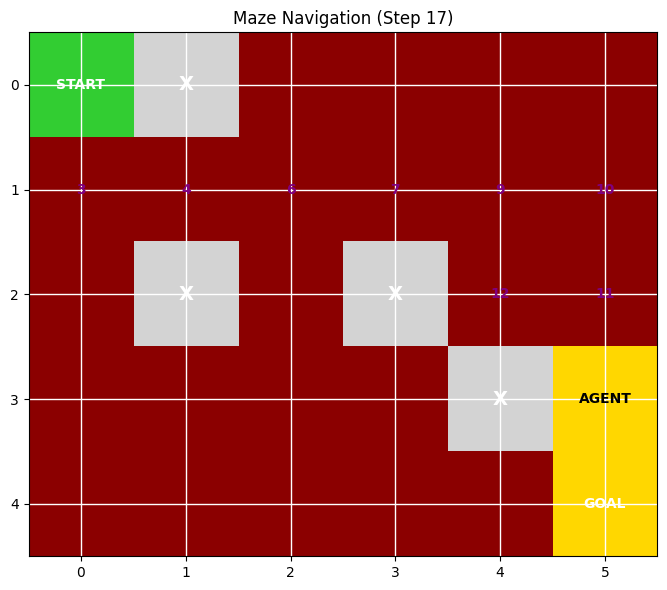


=== Step 18 ===
State: (3, 5), Action: DOWN, Next: (4, 5), Reward: 100


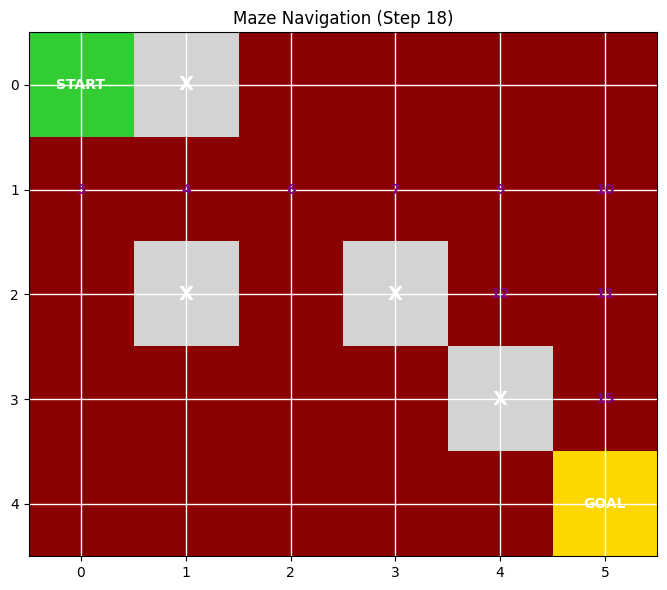


=== Navigation Complete ===
Final Path: [(0, 0), (0, 0), (0, 0), (1, 0), (1, 1), (1, 1), (1, 2), (1, 3), (1, 3), (1, 4), (1, 5), (2, 5), (2, 4), (2, 4), (2, 5), (3, 5), (3, 5), (3, 5), (4, 5)]
Total Steps: 18


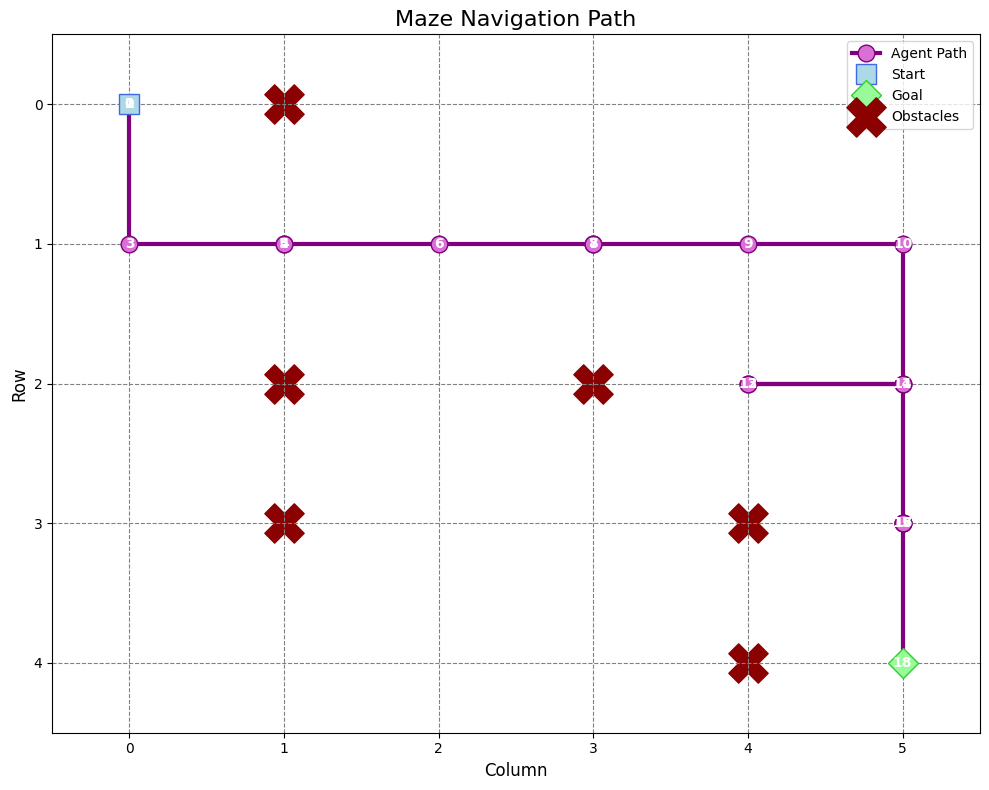


Execution Time: 13.62 seconds


In [1]:
"""
Stochastic Maze Navigation using Value Iteration
-----------------------------------------------
Implements an MDP solution for maze navigation with probabilistic movements.
The agent discovers obstacles dynamically and replans using value iteration.
"""

import random
import time
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# ======================
# GLOBAL CONFIGURATION
# ======================
ROWS, COLS = 5, 6
START_STATE = (0, 0)
GOAL_STATE = (4, 5)
TRUE_OBSTACLES = {(0, 1), (2, 1), (2, 3), (3, 1), (3, 4), (4, 4)}
ACTIONS = ['UP', 'DOWN', 'LEFT', 'RIGHT']
ACTION_PROBS = {
    'UP':    {'UP': 0.8, 'LEFT': 0.1, 'RIGHT': 0.1},
    'DOWN':  {'DOWN': 0.8, 'LEFT': 0.1, 'RIGHT': 0.1},
    'LEFT':  {'LEFT': 0.8, 'UP': 0.1, 'DOWN': 0.1},
    'RIGHT': {'RIGHT': 0.8, 'UP': 0.1, 'DOWN': 0.1},
}
VISUALIZE_EACH_STEP = True  # Set to False for faster execution

# ======================
# MAZE NAVIGATION CLASS
# ======================
class MazeNavigator:
    """Implements probabilistic maze navigation with dynamic obstacle discovery"""
    
    def __init__(self):
        self.known_obstacles = set()
        self.path_history = []
        self.value_history = []
        self.policy_history = []
        
    def is_out_of_bounds(self, state):
        r, c = state
        return r < 0 or r >= ROWS or c < 0 or c >= COLS

    def is_real_obstacle(self, state):
        return state in TRUE_OBSTACLES

    def get_next_state(self, state, action):
        r, c = state
        direction_map = {
            'UP': (r - 1, c),
            'DOWN': (r + 1, c),
            'LEFT': (r, c - 1),
            'RIGHT': (r, c + 1)
        }
        return direction_map[action]

    def get_all_states(self):
        return [(r, c) for r in range(ROWS) for c in range(COLS) 
                if (r, c) not in self.known_obstacles]

    # ======================
    # MDP SOLVING METHODS
    # ======================
    def value_iteration(self, gamma=0.9, epsilon=0.01):
        """Performs value iteration to solve the MDP"""
        states = self.get_all_states()
        V = {s: 0 for s in states}
        
        while True:
            delta = 0
            new_V = {}
            for state in states:
                if state == GOAL_STATE:
                    new_V[state] = 0
                    continue
                
                best_value = float('-inf')
                for action in ACTIONS:
                    exp_utility = self._calculate_expected_utility(state, action, V, gamma)
                    best_value = max(best_value, exp_utility)
                
                new_V[state] = best_value
                delta = max(delta, abs(new_V[state] - V.get(state, 0)))
            
            V = new_V
            if delta < epsilon:
                break
                
        return V

    def _calculate_expected_utility(self, state, action, V, gamma):
        """Helper for value iteration: calculates expected utility of an action"""
        exp_utility = 0
        for a_prime, prob in ACTION_PROBS[action].items():
            next_state = self.get_next_state(state, a_prime)
            
            # Handle invalid states
            if self.is_out_of_bounds(next_state) or next_state in self.known_obstacles:
                reward = -10
                next_state = state  # Stay in current state
            elif next_state == GOAL_STATE:
                reward = 100
            else:
                reward = -1
                
            exp_utility += prob * (reward + gamma * V.get(next_state, 0))
        return exp_utility

    def extract_policy(self, V):
        """Derives optimal policy from value function"""
        states = self.get_all_states()
        policy = {}
        
        for state in states:
            if state == GOAL_STATE:
                policy[state] = None
                continue
                
            best_action, best_value = None, float('-inf')
            for action in ACTIONS:
                exp_utility = self._calculate_expected_utility(state, action, V, gamma=0.9)
                if exp_utility > best_value:
                    best_value = exp_utility
                    best_action = action
                    
            policy[state] = best_action
            
        return policy

    # ======================
    # SIMULATION METHODS
    # ======================
    def execute_action(self, state, action):
        """Simulates action execution with probabilistic outcomes"""
        rand_val = random.random()
        cumulative = 0
        
        for a_prime, prob in ACTION_PROBS[action].items():
            cumulative += prob
            if rand_val < cumulative:
                next_state = self.get_next_state(state, a_prime)
                break
                
        # Handle collisions
        if self.is_out_of_bounds(next_state) or self.is_real_obstacle(next_state):
            self.known_obstacles.add(next_state)
            return state, -10
        return next_state, 100 if next_state == GOAL_STATE else -1

    def navigate(self):
        """Main navigation loop with dynamic replanning"""
        current_state = START_STATE
        self.path_history = [current_state]
        step = 1
        
        while current_state != GOAL_STATE:
            print(f"\n=== Step {step} ===")
            
            # Solve MDP
            V = self.value_iteration()
            policy = self.extract_policy(V)
            
            # Record history for visualization
            self.value_history.append(V.copy())
            self.policy_history.append(policy.copy())
            
            # Execute action
            if current_state not in policy or policy[current_state] is None:
                print("No valid policy from current state!")
                break
                
            action = policy[current_state]
            next_state, reward = self.execute_action(current_state, action)
            
            print(f"State: {current_state}, Action: {action}, " 
                  f"Next: {next_state}, Reward: {reward}")
            
            # Update state
            current_state = next_state
            self.path_history.append(current_state)
            
            # Visualize
            if VISUALIZE_EACH_STEP:
                self.visualize(current_state)
                time.sleep(0.5)
                
            step += 1
            
        # Final output
        print("\n=== Navigation Complete ===")
        print(f"Final Path: {self.path_history}")
        print(f"Total Steps: {len(self.path_history)-1}")
        self.visualize_final()

    # ======================
    # VISUALIZATION METHODS
    # ======================
    def visualize(self, agent_pos):
        """Dynamic visualization of current maze state"""
        grid = np.zeros((ROWS, COLS))
        
        # Create grid representation
        for r in range(ROWS):
            for c in range(COLS):
                if (r, c) in self.known_obstacles:
                    grid[r, c] = -1
                elif (r, c) == START_STATE:
                    grid[r, c] = 2
                elif (r, c) == GOAL_STATE:
                    grid[r, c] = 3
                elif (r, c) == agent_pos:
                    grid[r, c] = 4
                else:
                    grid[r, c] = 0

        # Create colormap
        cmap = ListedColormap(['lightgray', 'darkred', 'royalblue', 'limegreen', 'gold'])
        norm = plt.Normalize(vmin=-1, vmax=4)
        
        # Plot grid
        plt.figure(figsize=(8, 6))
        plt.imshow(grid, cmap=cmap, norm=norm, interpolation='nearest')
        
        # Add annotations
        for r in range(ROWS):
            for c in range(COLS):
                if (r, c) in self.known_obstacles:
                    plt.text(c, r, 'X', ha='center', va='center', 
                            color='white', fontweight='bold', fontsize=14)
                elif (r, c) == START_STATE:
                    plt.text(c, r, 'START', ha='center', va='center', 
                            color='white', fontweight='bold')
                elif (r, c) == GOAL_STATE:
                    plt.text(c, r, 'GOAL', ha='center', va='center', 
                            color='white', fontweight='bold')
                elif grid[r, c] == 4:  # Agent position
                    plt.text(c, r, 'AGENT', ha='center', va='center', 
                            color='black', fontweight='bold')
                elif (r, c) in self.path_history:
                    idx = self.path_history.index((r, c))
                    plt.text(c, r, str(idx), ha='center', va='center', 
                            color='purple', fontweight='bold')
        
        plt.title(f"Maze Navigation (Step {len(self.path_history)-1})")
        plt.xticks(range(COLS))
        plt.yticks(range(ROWS))
        plt.grid(color='white', linestyle='-', linewidth=1)
        plt.tight_layout()
        plt.show(block=False)
        plt.pause(0.1)
        plt.close()

    def visualize_final(self):
        """Comprehensive visualization of entire path"""
        plt.figure(figsize=(10, 8))
        
        # Create path visualization
        path_arr = np.array(self.path_history)
        plt.plot(path_arr[:,1], path_arr[:,0], 'o-', 
                linewidth=3, markersize=12, color='purple', 
                markerfacecolor='orchid', label='Agent Path')
        
        # Mark special points
        plt.plot(START_STATE[1], START_STATE[0], 's', markersize=15, 
                color='royalblue', label='Start', markerfacecolor='lightblue')
        plt.plot(GOAL_STATE[1], GOAL_STATE[0], 'D', markersize=15, 
                color='limegreen', label='Goal', markerfacecolor='palegreen')
        
        # Add obstacles
        obs_arr = np.array(list(TRUE_OBSTACLES))
        plt.scatter(obs_arr[:,1], obs_arr[:,0], s=800, marker='X', 
                   color='darkred', label='Obstacles')
        
        # Configure plot
        plt.xlim(-0.5, COLS-0.5)
        plt.ylim(ROWS-0.5, -0.5)  # Invert y-axis for matrix coordinates
        plt.xticks(range(COLS))
        plt.yticks(range(ROWS))
        plt.grid(True, color='gray', linestyle='--')
        plt.title("Maze Navigation Path", fontsize=16)
        plt.xlabel("Column", fontsize=12)
        plt.ylabel("Row", fontsize=12)
        plt.legend(loc='upper right')
        
        # Add annotations
        for i, (r, c) in enumerate(self.path_history):
            plt.text(c, r, str(i), ha='center', va='center', 
                    color='white', fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('maze_path.png', dpi=300)
        plt.show()

# ======================
# MAIN EXECUTION
# ======================
if __name__ == "__main__":
    print("Starting Stochastic Maze Navigation...")
    print(f"Maze Size: {ROWS}x{COLS}")
    print(f"Start: {START_STATE}, Goal: {GOAL_STATE}")
    print(f"True Obstacles: {TRUE_OBSTACLES}")
    
    navigator = MazeNavigator()
    start_time = time.time()
    navigator.navigate()
    
    duration = time.time() - start_time
    print(f"\nExecution Time: {duration:.2f} seconds")